# Topic Modeling: Design Phase - Part 2

In this notebook you will perform topic modeling by using a technique known as [Latent Dirichlet Allocation](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2) (LDA for short). Then, you will quantitatively compare the different models using a metric suited to measure the coherence of the topics generated.


The steps you will complete in this lab are:
1. Import Python packages
2. Load the dataset
3. Represent the data as Bag-of-Words
4. Get a base LDA model
5. Introducing the Coherence Score Metric
6. Topic Modeling with LDA
7. Select and evaluate the final LDA model
8. Removing additional words (optional)

**Note:** In all other case studies in this specialization, you have worked with examples of supervised learning, where you trained a model to learn the mapping from and input A to an output B. In this lab, you'll be developing an unsupervised learning model, which is to say, there are no labels or explicit right answers to train on. Your model will be looking for statistical similarities between the text of different messages in order to group them into topics. This sort of task is common in unsupervised learning projects, where you're often attempting to discover relationships or patterns in your data and draw inferences based on those patterns or relationships.  

## 1. Import Python packages

Run the next cell to import that Python packages you'll need for this lab.

Note the `import utils` line. This line imports the functions that were specifically written for this lab. If you want to look at what these functions are, go to `File -> Open...` and open the `utils.py` file to have a look.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from termcolor import colored
import random
import gensim
import pandas as pd

import utils


print('All packages imported successfully!')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


All packages imported successfully!


## 2. Load the dataset

Begin by loading in the cleaned dataframe from the last ungraded lab (that is saved in a `.pkl` file):

In [2]:
haiti_df = pd.read_pickle("./data/haiti_df_processed.pkl")

haiti_df.head(5)

,id,split,message,original,genre,related,PII,request,offer,aid_related,...,earthquake,cold,other_weather,direct_report,event,actionable_haiti,date_haiti,message_tokens,num_words,num_tokens
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,haiti_earthquake,0,2010-02-09,"[weather, update, cold, front, cuba, could, pa...",13,8
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,...,0,0,0,0,haiti_earthquake,0,2010-01-17,[hurricane],9,1
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,haiti_earthquake,0,2010-01-17,"[say, west, side, haiti, rest, country, today,...",12,8
3,14,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,...,0,0,0,0,haiti_earthquake,0,2010-01-17,"[information, national, palace-]",5,3
4,15,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,...,0,0,0,0,haiti_earthquake,0,2010-01-17,"[storm, sacred, heart, jesus]",6,4


## 3. Represent the data as Bag-of-Words

Now you will convert the messages in the dataset into their BOW representation and generate other useful information such as a list containing all words in the corpus:

In [3]:
# All of the messages in the dataset
corpus = haiti_df.message_tokens

# Create the dictionary
corpus_dictionary = gensim.corpora.Dictionary(corpus)

# Filter out words that occur less than 5 times overall
corpus_dictionary.filter_extremes(no_below=5)

# Create a bag of words out of the full corpus
corpus_bow = [corpus_dictionary.doc2bow(doc) for doc in corpus]

# All words in the dictionary
all_words = list(corpus_dictionary.values())

print(f"Dictionary contains a total of {len(all_words)} unique words")

Dictionary contains a total of 1604 unique words


## 4. Get a base LDA model

There are several algorithms to perform topic modeling, as well as several Python libraries for this purpose. In this section you will perform topic modeling using Latent Dirichlet Allocation (LDA) with Gensim and pyLDAvis (for visualization). The three methods and libraries you will use are:

Latent Dirichlet Allocation (LDA) is a generative probabilistic topic model that aims to uncover latent (or hidden) topics from a corpus. The corpus in this case is the collection of processed and tokenized messages. After topic modeling, each document is represented by a distribution over the topics that were found in the entire corpus.

To interact with the LDA models you will be using the amazing library [Gensim](https://github.com/RaRe-Technologies/gensim). This library provides a lot of features for performing various NLP-related tasks. In fact, you already used it at the beginning of the lab to generate the BOW representation of the corpus.

To train a LDA model on a corpus you can use the [LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html) class. In the next cell you will use it to train the model (it is abstracted in the `utils.train_lda_model` fumction) on the corpus data.

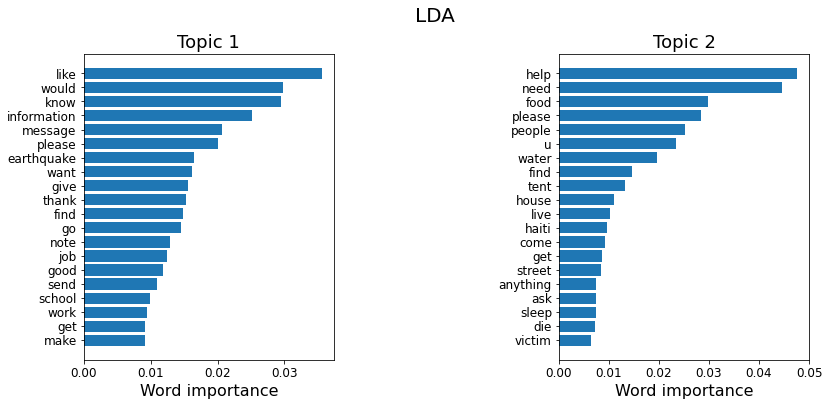

In [4]:
num_topics = 2
lda_2_topics = utils.train_lda_model(num_topics=num_topics, corpus_bow=corpus_bow, corpus=corpus, corpus_dictionary=corpus_dictionary)
utils.plot_top_words_lda(num_topics, lda_2_topics.model)

## 5 Introducing the Coherence Score Metric

A common metric to compare models that aim at capturing topics from a corpus is the `coherence score`. This metric arises from the idea that "a set of statements or facts are said to be coherent if they support each other". This quote is taken from the paper [Exploring the Space of Topic Coherence Measures](https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf), in case you want to look into the details on this subject.

A nice and simple explanation can be also found here:

- [Understanding Topic Coherence Measures](https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c)

More resources:

- [Evaluating topic coherence measures](https://mimno.infosci.cornell.edu/nips2013ws/nips2013tm_submission_7.pdf)

To compute this metric the `compute_coherence_score` function is used. This function uses Gensim's [CoherenceModel](https://radimrehurek.com/gensim/models/coherencemodel.html) class to compute the score for any given list of topics and corpus.

**This metric is defined in such a way that values closer to 0 reflect a greater coherence**. 

To test it you will use two examples. One has the actual 10 top words for the topics (taken from the model) and the other is a random collection of words from the corpus. Notice that both examples have two lists of words which means that they simulate having two topics:

In [5]:
real_top_words = utils.get_top_words_lda(num_topics, lda_2_topics.model, num_words=10)

random_topics = [
    random.sample(all_words, 10),
    random.sample(all_words, 10),    
]

print(f"Top words:")
for word_list in real_top_words:
    print(f"    {word_list}")
print(f"Coherence score for the text using calculated topics is: {utils.compute_coherence_score(real_top_words, dictionary=corpus_dictionary, texts=corpus.values, corpus=corpus_bow):.3f}\n")

print(f"Random words:")
for word_list in random_topics:
    print(f"    {word_list}")
print(f"Coherence score for the text using random topics is: {utils.compute_coherence_score(random_topics, dictionary=corpus_dictionary, texts=corpus.values, corpus=corpus_bow):.3f}")

Top words:
    ['like', 'would', 'know', 'information', 'message', 'please', 'earthquake', 'want', 'give', 'thank']
    ['help', 'need', 'food', 'please', 'people', 'u', 'water', 'find', 'tent', 'house']
Coherence score for the text using calculated topics is: -2.347

Random words:
    ['earthquake', 'g', '1', 'jobless', 'small', '11', 'prince', '54', 'towards', 'want']
    ['solidarite', 'huge', 'interested', 'first', 'wish', 'yo', 'wich', 'future', 'identity', 'response']
Coherence score for the text using random topics is: -18.536


If you run the previous cell multiple times you will get a different score for the random words (as different words are sampled with each run) but the score should always be around -20.

As you would expect, there is a significant difference between actual top words of a topic and random words!

## 6. Topic Modeling with LDA
### 6.1 Computing models with different number of topics

Now that you have a way to compare the coherence of a collection of words, you can use this to measure the performance of LDA topic modeling algorithms by evaluating the coherence of the top words of each topic.
You will now compute the coherence score for the LDA models ranging from 2 to 6 topics. But first you have to train the models:

In [6]:
# Set the number of topics
max_number_of_topics = 6
n_topics_range = range(2, max_number_of_topics + 1)

# Dictionary to save trained models
LDA_models = {}
print(f"Training LDA models from 2 to {max_number_of_topics} topics")

# For number of topics ranging from 2 to max_number_of_topics
for i in n_topics_range:
    # Save model
    LDA_models[i] = utils.train_lda_model(num_topics=i, corpus_bow=corpus_bow, corpus=corpus, corpus_dictionary=corpus_dictionary) # Training all models takes around 2 mins
    print(f"Successfully trained LDA model on {i} topics")

Training LDA models from 2 to 6 topics
Successfully trained LDA model on 2 topics
Successfully trained LDA model on 3 topics
Successfully trained LDA model on 4 topics
Successfully trained LDA model on 5 topics
Successfully trained LDA model on 6 topics


### 6.2 Explore top words for different number of topics

The coherence score metric is not perfect and within the subject of topic modeling there is no labeled ground truth, it all depends on what you are trying to accomplish. Have a look at the top words of each of the topics for models trained for different number of topics. While you can observe the coherence score as one metric of performance for different models, also look closely to get a sense of how human interpretation comes into this form of modeling, namely, despite whatever the coherence score says, can you get a sense of which models are producing more clearly relevant topics? Human interpretability is a key component of topic modeling in this way. 

In [7]:
utils.top_words_plot(LDA_models, max_number_of_topics)

interactive(children=(Dropdown(description='# of topics', options=(2, 3, 4, 5, 6), value=2), Output()), _dom_c…

### 6.3 Compare coherence scores

Now compute the coherence score for each model. Create a plot so it is easier to visualize:

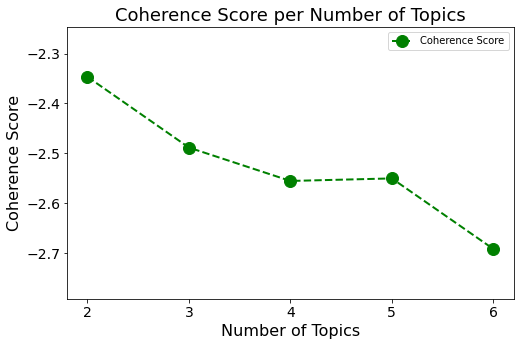

In [8]:
# save coherence scores in a list
coherence_scores_lda = [LDA_models[i].coherence_score for i in n_topics_range]

# plot coherence score as a function of number of topics
utils.plot_coherences_lda(n_topics_range, coherence_scores_lda)

## 7. Select and evaluate the final LDA model
According to the plot above, the optimal mumber of Topics is two (this may vary if you choose different words to exclude - see step 8). So you can select the model with two topics as your final model.

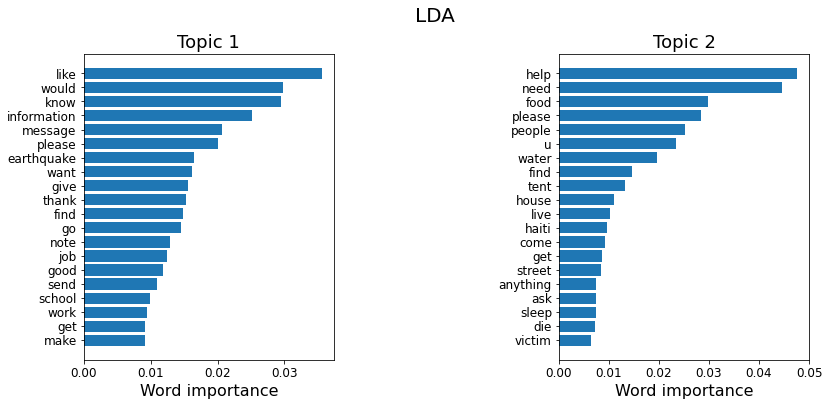

In [9]:
num_topics = 2

# Select the model from the trained models
lda_model_final = LDA_models[num_topics]

# Plot the top ten words for the selected model again
utils.plot_top_words_lda(num_topics, lda_model_final.model, num_words=20)

### 7.1 Analyze topic modeling of individual messages

Now, you can use the model as something like a multiclass classification model. Here you will analyze one message at a time, and determine how well it belongs to each topic. 

In [10]:
# Here you can select a category of messages and look into what topic the single message would be classified
utils.interact_with_filters(utils.plot_random_message_classification, haiti_df, corpus_dictionary=corpus_dictionary, lda_topics=lda_model_final)

interactive(children=(Dropdown(description='Data to show', options=('All', 'medical_help', 'medical_products',…

### 7.2 Topic importance as a function of time
Plot the topic importance over time in the next cell. For each of the topics the importance is calculated in each week after the disaster. You can see that the importance of some topics increases with time while it decreases for other topics. Try to see if this makes sense based on the top words of each topic.

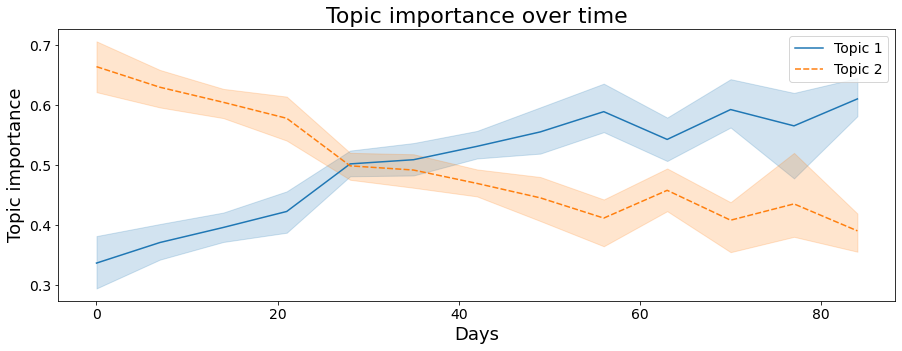

In [11]:
utils.plot_topic_importance(corpus_bow, haiti_df, lda_model_final, num_topics)

## 8. Removing additional words (optional)

There are some words that are captured by the topic models as relevant because of their frequency, but are not really meaningful. In such cases, you can help the model by removing such words when you detect them. Examples of those words are 'like', 'would'. In the next cell you can include a list of words that the model must ignore. This is an important task where you can help the AI model. What other words do you identify? What do you think about 'please', 'need', and 'want'?

In [12]:
# You can run this cell as many times as needed
words_to_exclude = ['like', 'would']#, 'need', 'please'] # Add other words that you consider not important. 
print(f"Before removal:\nDictionary contains a total of {len(corpus_dictionary)} unique words\n")
utils.exclude_words_from_dictionary(corpus_dictionary, words_to_exclude)

# Create bag of words out of the full corpus
corpus_bow = [corpus_dictionary.doc2bow(doc) for doc in corpus]
# All words in the dictionary
all_words = list(corpus_dictionary.values())
print(f"\nAfter removal:\nDictionary contains a total of {len(all_words)} unique words")

Before removal:
Dictionary contains a total of 1604 unique words


After removal:
Dictionary contains a total of 1602 unique words


When you remove the words you can return back to step 6 and try how the models perform with some of the words removed. If you want to reset your dictionary and BOW, you can return to step 3 and run the cells there to restore them.

## Additional optional challenge / exploration

**Look at topic modeling without removing any stopwords!**

Run the cell below and then return to **step 3** above and run the cells in order to perform all the analysis in this lab without removing stopwords to see what you find. Here you'll read in the dataset again from scratch and then process the messages into tokens without removing stopwords. 

If you're a Python programmer, another thing you can try at this stage is looking at topic modeling for the other events captured in the dataset; Hurricane Sandy in the U.S. in 2012 or the Pakistan floods in 2010. You'll just need to change the filter below from `haiti_earthquake` to one of the other events, `usa_sandy` or `pakistan_floods`. But keep in mind the other events don't have dates associated with them so you'll need to comment out or modify any lines of code that are operating on the dates. 

Once you have loaded the data for a separate event, you'll have the option or training a new model for that event, or trying out your model trained on the Haiti data to see how it performs on another event. Try both if you're feeling ambitious and see what you find!

In [13]:
# OPTIONAL CHALLENGE / EXPLORATION: 
# Run the following lines of code to reload the data and tokenize without removing stopwords to see what happens
# Load the datasets
training_data = pd.read_csv("data/disaster_response_training.csv", low_memory=False)
validation_data = pd.read_csv("data/disaster_response_validation.csv", low_memory=False)
test_data = pd.read_csv("data/disaster_response_test.csv", low_memory=False)
# Merge the three datasets
full_data = training_data.append(validation_data).append(test_data)
# Fix column data type
full_data['original'] = full_data['original'].astype(str)
# Select only the Haiti data
haiti_df = full_data[full_data.event == 'haiti_earthquake']
# Fix column data type
haiti_df['actionable_haiti'] = haiti_df.actionable_haiti.astype('int64')
haiti_df['date_haiti'] = pd.to_datetime(haiti_df.date_haiti)
# Get stopwords and punctuation from the utils file
STOP_WORDS = [] #utils.STOP_WORDS
punctuation = utils.punctuation
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()
# Process all messages and save tokens to a new column
haiti_df["message_tokens"] = haiti_df.message.apply(
    utils.process_text,
    tokenizer=word_tokenize, pos_tagger=nltk.pos_tag, lemmatizer=lemmatizer, stopwords=STOP_WORDS, punctuation=punctuation
)
haiti_df.head()

,id,split,message,original,genre,related,PII,request,offer,aid_related,...,storm,fire,earthquake,cold,other_weather,direct_report,event,actionable_haiti,date_haiti,message_tokens
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,0,0,haiti_earthquake,0,2010-02-09,"[weather, update, a, cold, front, from, cuba, ..."
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,...,1,0,0,0,0,0,haiti_earthquake,0,2010-01-17,"[be, the, hurricane, over, or, be, it, not, over]"
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,0,0,haiti_earthquake,0,2010-01-17,"[say, west, side, of, haiti, rest, of, the, co..."
3,14,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,...,0,0,0,0,0,0,haiti_earthquake,0,2010-01-17,"[information, about, the, national, palace-]"
4,15,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,...,1,0,0,0,0,0,haiti_earthquake,0,2010-01-17,"[storm, at, sacred, heart, of, jesus]"
